In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# import scienceplots
import matplotlib as mpl
import networkx as nx
import random
import matplotlib.cm as cm
from matplotlib.patches import Patch

from matplotlib.patches import FancyArrowPatch

import copy


# plt.style.use('science')
mpl.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Times New Roman"]
plt.rcParams["font.size"] = 12

pi= np.pi



## System Dynamics

In [2]:


def kuramoto_ode(y, t, alpha, w, A):
    # A is the weighted adjacency matrix which encompasses the coupling stength over each edge 
    N = len(w)
    theta = y[:N]
    omega = y[N:]
    
    dtheta_dt = omega
    domega_dt = w - (alpha * omega) + np.sum(A * np.sin(theta[None, :] - theta[:, None]), axis=1)
    
    return np.concatenate([dtheta_dt, domega_dt])


## Order Parameter

def order_parameter(theta):
    N = len(theta)
    r = np.abs(np.sum(np.exp(1j * theta)) / N)
    return r

def order_parameter_time_series(theta_series):
    N = len(theta_series[0])
    r = np.zeros(len(theta_series))
    for i in range(len(theta_series)):
        r[i] = order_parameter(theta_series[i])
    return r

def power_delivered_time_series(theta_ts, A):

    T, N = theta_ts.shape
    P_ts = np.zeros((T, N))

    for t in range(T):
        theta = theta_ts[t]
        for i in range(N):
            for j in range(N):
                if A[i, j] != 0:
                    P_ts[t, i] += A[i, j] * np.sin(theta[j] - theta[i])

    return P_ts



## Network

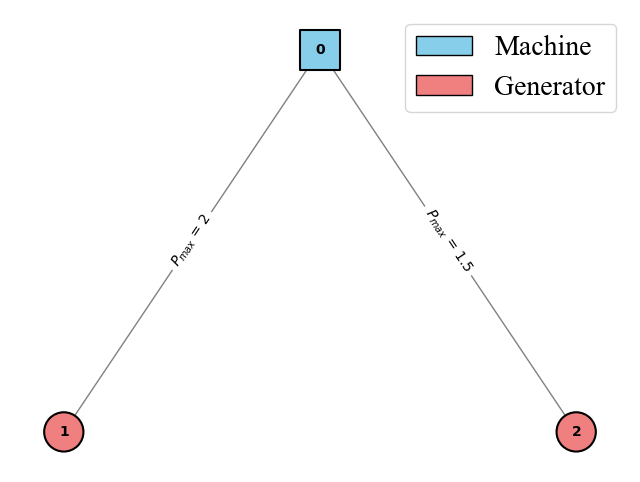

In [ ]:

legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='Machine'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Generator')
]


p_i = np.array([-2, 1, 1],dtype=float)

plt.figure(figsize=(8, 6))


G = nx.Graph()


G.add_nodes_from([0, 1, 2])


edges = [
    (0, 1, 2),
    (0, 2, 1.5)
]

# Add edges
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Define node styles
node_styles = {
    0: ('s', 'skyblue'),  # Generator
    1: ('o', 'lightcoral'),     # Machine
    2: ('o', 'lightcoral')   # Generator
}


pos = {
    0: (0, 0),   
    1: (-1, -1),
    2: (1, -1)   
}


for shape in set(shape for shape, _ in node_styles.values()):
    nodes = [n for n in G.nodes if node_styles[n][0] == shape]
    colors = [node_styles[n][1] for n in nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes,
                           node_shape=shape, node_color=colors,
                           edgecolors='black', linewidths=1.5, node_size=800)


nx.draw_networkx_edges(G, pos, edge_color='gray')


edge_labels = {(u, v): f"$P_{{max}}$ = {w}" for (u, v, w) in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.legend(handles=legend_elements, loc='upper right', frameon=True,fontsize = 20)
plt.axis('off')
# plt.savefig('network_diagram.pdf', dpi=1200, bbox_inches='tight',transparent=True)
plt.show()
A = nx.to_numpy_array(G)



### Regular Operation

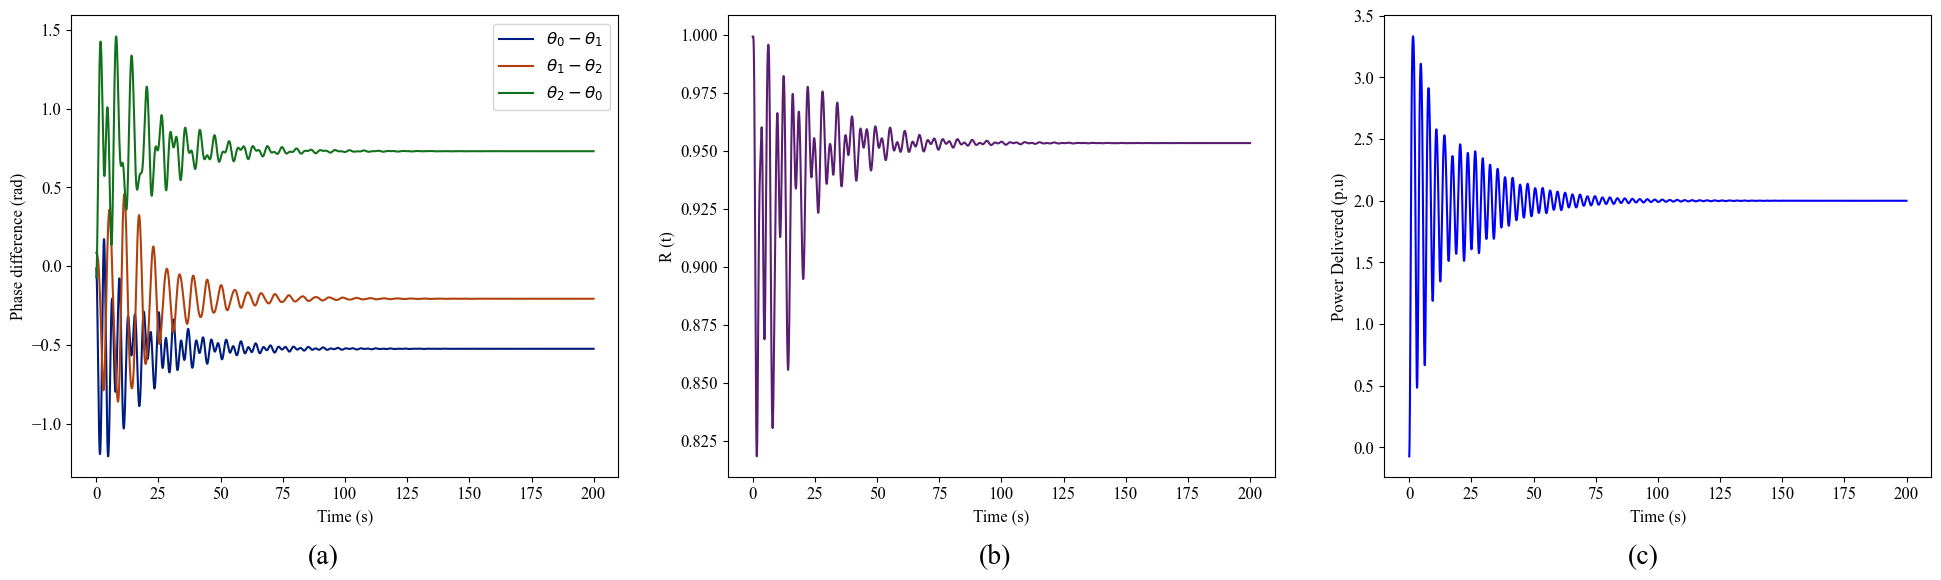

In [ ]:
import seaborn as sns

palette=sns.color_palette("dark", 10)
def simulate_kuramoto(A,T, dt,w,initial_conditions=None,alpha=0.1):

    np.random.seed(2699)  # For reproducibility
    N = A.shape[0]
    t = np.arange(0, T, dt)
    if initial_conditions is None:
        y0 = np.concatenate([np.random.uniform(-pi/20, pi/20, N), np.zeros(N)])  
    else :
        y0 = initial_conditions

    sol = odeint(kuramoto_ode, y0, t, args=(alpha, w, A))
    theta = sol[:, :N]
    theta_dot = sol[:, N:]
    r = order_parameter_time_series(theta)
    return t, theta,theta_dot, r

omega = p_i
T_i= 200
dt = 0.05
t, theta,theta_dot, r = simulate_kuramoto(A,T_i, dt,omega)
power  = power_delivered_time_series(theta, A)

# --- Create a figure with two subplots side by side ---
fig, axs = plt.subplots(ncols=3, figsize=(24, 6))  # Adjust width for clarity

# --- Left plot: Phases over time ---
for i in range(theta.shape[1]):
    axs[0].plot(t, theta[:, i] - theta[:,(i+1)%3], label=f'$\\theta_{{{i}}} - \\theta_{{{(i+1)%3}}} $',color = palette[i])
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Phase difference (rad)")
axs[0].legend()
# axs[0].set_title("Phase Evolution")

axs[1].plot(t,r,color= palette[4]
            )
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("R (t)")
# axs[1].set_ylim(0, 3)
# axs[1].set_xlim(0, 200)

# --- Right plot: Order parameter over time ---
axs[2].plot(t, power[:,0], color='blue')
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Power Delivered (p.u)")

fig.text(0.23, -0.001, "(a)", ha='center', va='top', fontsize=20)
fig.text(0.51, -0.001, "(b)", ha='center', va='top', fontsize=20)
fig.text(0.78, -0.001, "(c)", ha='center', va='top', fontsize=20)

# plt.savefig("Phase ,r, power.pdf", dpi=1200, bbox_inches='tight', transparent=True)
plt.show()


### Under Pertubation

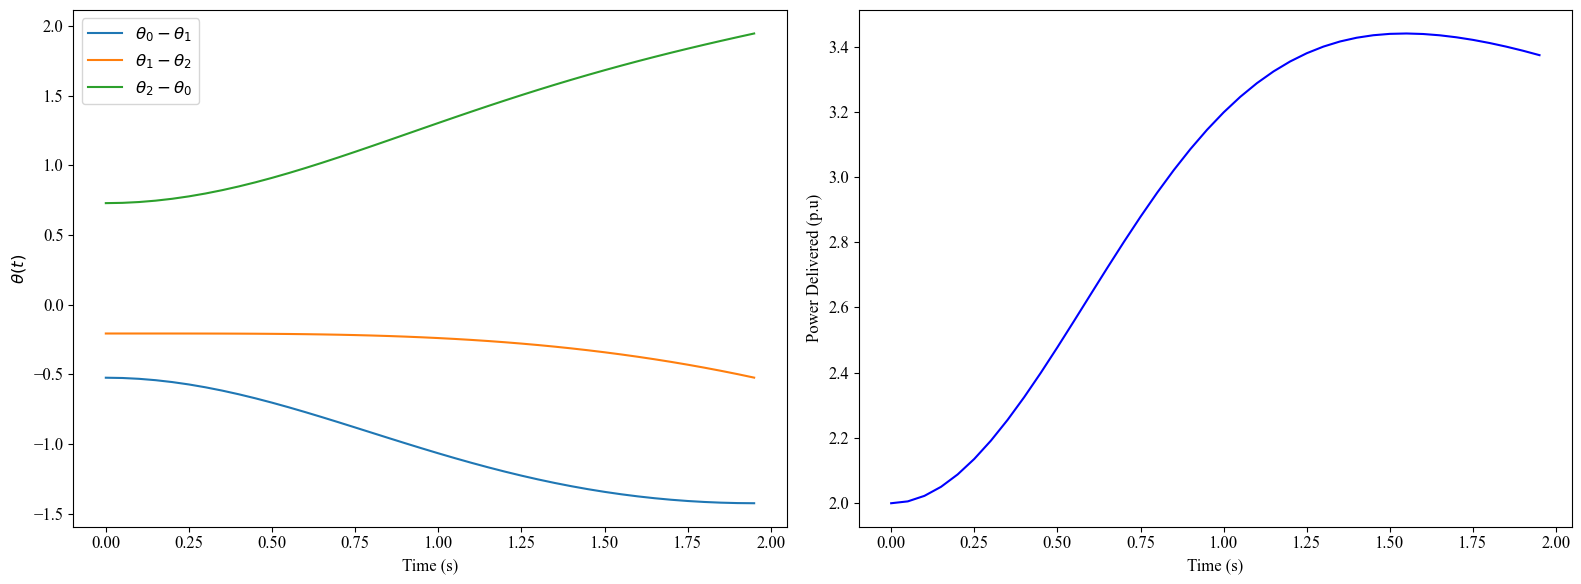

In [5]:

delta_t = 2
#######################Defining Perturbation strength###########################
# delta_p =  1.8 ## Max perturbation
# delta_p = 1.7 ## Max perturbation 
delta_p = 1.6 ## Max perturbation
################################################################################################
p_i_new = copy.copy(p_i)

p_i_new[0] = p_i_new[0] - delta_p


A = nx.to_numpy_array(G)  

inital_conditions = np.concatenate([theta[-1,:], theta_dot[-1,:]])


omega = p_i_new
T_f= delta_t
dt = 0.05
t_fault, theta_fault,theta_dot_fault, r_fault = simulate_kuramoto(A,T_f, dt,omega,initial_conditions=inital_conditions)

# --- Left plot: Phases over time ---
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))  # Adjust width for clarity

# --- Left plot: Phases over time ---
for i in range(theta.shape[1]):
    axs[0].plot(t_fault, theta_fault[:, i] - theta_fault[:,(i+1)%3], label=f'$\\theta_{{{i}}} - \\theta_{{{(i+1)%3}}} $')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$\\theta(t)$")
axs[0].legend()

power_f  = power_delivered_time_series(theta_fault, A)

# --- Right plot: Order parameter over time ---
axs[1].plot(t_fault,power_f[:,0], color='blue')
 
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Power Delivered (p.u)")
# axs[1].set_title("Order Parameter")

plt.tight_layout()
# plt.savefig("Phase and order parameter.png", dpi=1200, bbox_inches='tight', transparent=True)
plt.show()




### Recovery from pertubation

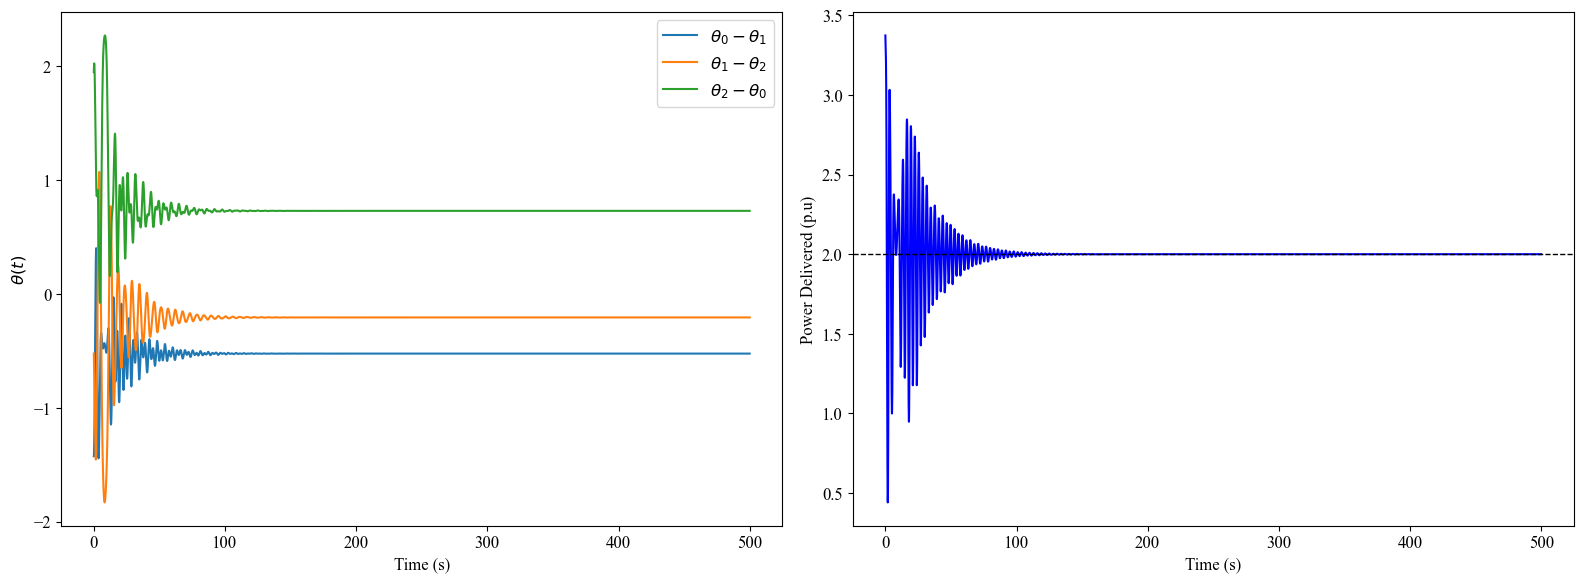

In [6]:

inital_conditions = np.concatenate([theta_fault[-1,:], theta_dot_fault[-1,:]])
omega = p_i
T_r= 500
dt = 0.05
t_re, theta_re,theta_dot_re, r_re = simulate_kuramoto(A,T_r, dt,omega,initial_conditions=inital_conditions)
power_re  = power_delivered_time_series(theta_re, A)

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))  # Adjust width for clarity

# --- Left plot: Phases over time ---
for i in range(theta_re.shape[1]):
    axs[0].plot(t_re, theta_re[:, i] - theta_re[:,(i+1)%3], label=f'$\\theta_{{{i}}} - \\theta_{{{(i+1)%3}}} $')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("$\\theta(t)$")
axs[0].legend()
# axs[0].set_title("Phase Evolution")

# --- Right plot: Order parameter over time ---
axs[1].plot(t_re,power_re[:,0], color='blue')
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Power Delivered (p.u)")
axs[1].axhline(2, color='black', linestyle='--', linewidth=1)
# axs[1].set_title("Order Parameter")

plt.tight_layout()
# plt.savefig("Phase and order parameter.png", dpi=1200, bbox_inches='tight', transparent=True)
plt.show()




## Plotting

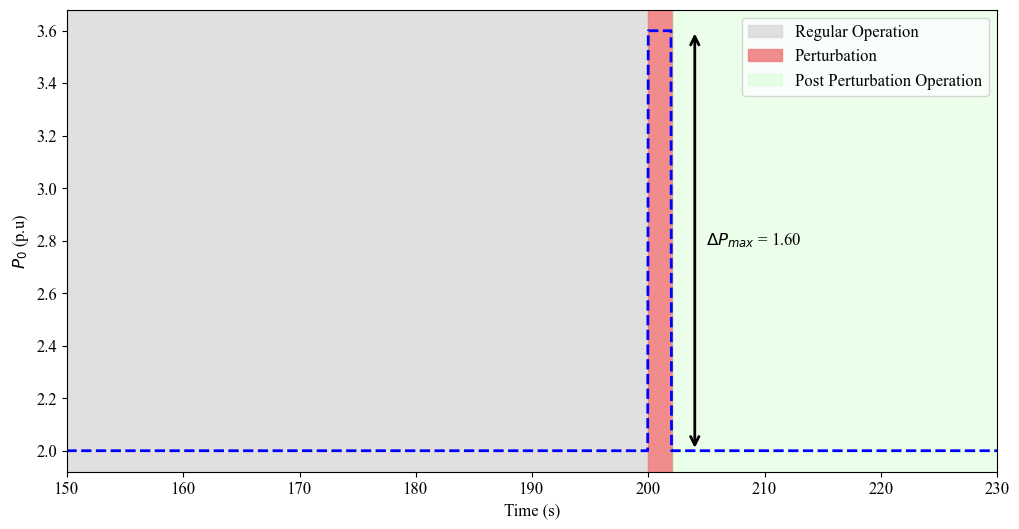

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


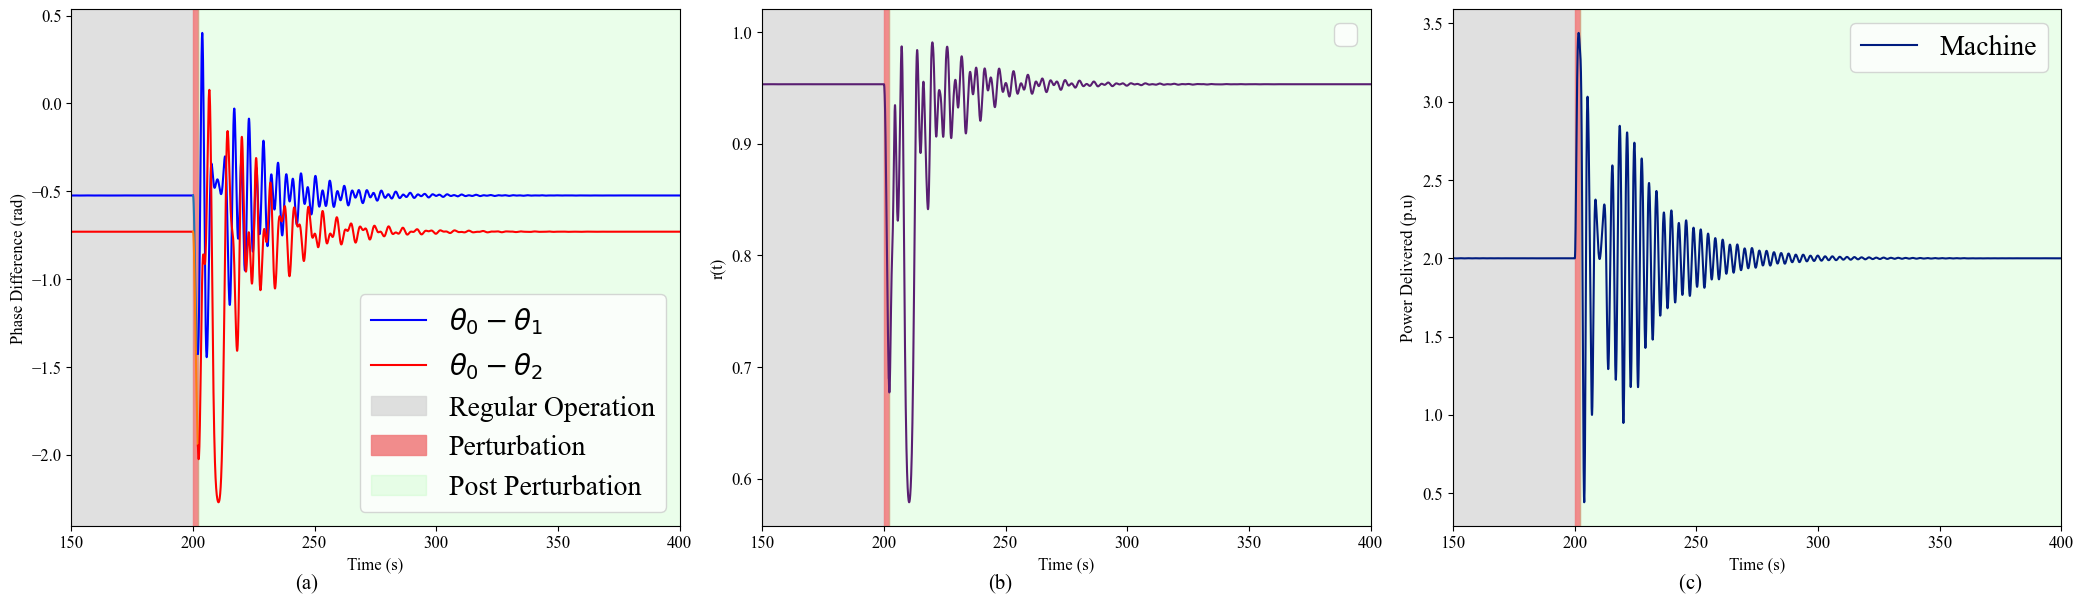

In [ ]:
theta_combined = np.concatenate([copy.copy(theta),copy.copy(theta_fault),copy.copy(theta_re)])
theta_dot_combined = np.concatenate([theta_dot,theta_dot_fault,theta_dot_re])
r_combined = np.concatenate([r,r_fault,r_re])   
t_combined = np.concatenate([copy.copy(t),copy.copy(t_fault) +T_i,copy.copy(t_re) + T_f + T_i])

P_ts = np.concatenate([power,power_f,power_re])#power_delivered_time_series(theta_combined, A)


# --- Define desired time window ---
t_min, t_max = 150, T_i + T_f + T_r
mask = (t_combined >= t_min) & (t_combined <= t_max)

# Apply mask to all arrays
t_window = np.unique(t_combined[(t_combined >= t_min) & (t_combined <= t_max)])#t_combined[mask]
theta_window = np.unique(theta_combined[(t_combined >= t_min) & (t_combined <= t_max),:])#theta_combined[mask]
P_window = np.unique(P_ts[(t_combined >= t_min) & (t_combined <= t_max)])#P_ts[mask]
r_window = np.unique(r_combined[(t_combined >= t_min) & (t_combined <= t_max)])#r_combined[mask]


mask = (t_combined >= t_min) & (t_combined <= t_max)
t_window = t_combined[mask]
theta_window = theta_combined[mask, :]
P_window = P_ts[mask]
r_window = r_combined[mask]

# Optionally remove duplicate time entries safely
_, unique_indices = np.unique(t_window, return_index=True)
t_window = t_window[unique_indices]
theta_window = theta_window[unique_indices]
P_window = P_window[unique_indices]
fault_start, fault_end = T_i, T_i + T_f
recovery_start, recovery_end = T_i + T_f, t_max


P_machine = np.ones((len(t), 1)) * p_i[0]

P_machine = np.concatenate([P_machine,  np.ones((len(t_fault), 1)) * p_i_new[0]], axis=0)

P_machine = np.concatenate([P_machine,  np.ones((len(t_re), 1)) * p_i[0]], axis=0)


plt.figure(figsize=(12, 6))

# Peak value
peak_value = np.max(-P_machine)
base_value = np.min(-P_machine)  # Or set it to 0 if that's your baseline

# Plot main curve
plt.plot(t_combined, -P_machine, color='blue', linestyle='--', linewidth=2)
plt.xlim(t_min, 230)

# Highlight regions
plt.axvspan(t_min, fault_start, color='lightgrey', alpha=0.7, label='Regular Operation')
plt.axvspan(fault_start, fault_end, color='lightcoral', alpha=0.9, label='Perturbation')
plt.axvspan(recovery_start, recovery_end, color='palegreen', alpha=0.2, label='Post Perturbation Operation')

# --- Add vertical double arrow to indicate peak height ---
arrow_x = fault_end + 2  # place arrow just after perturbation
arrow = FancyArrowPatch((arrow_x, base_value), (arrow_x, peak_value),
                        arrowstyle='<->', mutation_scale=15, color='black', linewidth=2)
plt.gca().add_patch(arrow)

# --- Label the height ---
plt.text(arrow_x + 1, (base_value + peak_value) / 2, 
         f"$\\Delta P_{{max}}$ = {peak_value - 2:.2f}", 
         va='center', fontsize=12)

# Axis labels and legend
plt.xlabel("Time (s)")
plt.ylabel("$P_0$ (p.u)")
plt.legend()

# plt.savefig("perturbation_peak_height.pdf", dpi=1200, bbox_inches='tight', transparent=True)
plt.show()


# Define regions (example)
fault_start, fault_end = T_i, T_i + T_f
recovery_start, recovery_end = T_i + T_f, t_max


fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(21, 6), sharex=True)


axs[0].plot(t, theta[:, 0] - theta[:, 1], label=r'$\theta_0 - \theta_1$', color="blue")
axs[0].plot(t, theta[:, 0] - theta[:, 2], label=r'$\theta_0 - \theta_2$', color="red")
axs[0].plot(t_fault + T_i, theta_fault[:, 0] - theta_fault[:, 1])#, label=r'$\theta_0 - \theta_1$', color="blue")
axs[0].plot(t_fault +T_i, theta_fault[:, 0] - theta_fault[:, 2])# label=r'$\theta_0 - \theta_2$', color="red")
axs[0].plot(t_fault, theta_fault[:, 0] - theta_fault[:, 1],  color="blue")
axs[0].plot(t_fault, theta_fault[:, 0] - theta_fault[:, 2], color="red")
axs[0].plot(t_re+ T_i+T_f, theta_re[:, 0] - theta_re[:, 1],color="blue")# label=r'$\theta_0 - \theta_1$', color="blue")
axs[0].plot(t_re + T_i +T_f, theta_re[:, 0] - theta_re[:, 2],color='red')# label=r'$\theta_0 - \theta_2$', color="red")

axs[0].axvspan(t_min, fault_start, color='lightgrey', alpha=0.7, label='Regular Operation')
axs[0].axvspan(fault_start, fault_end, color='lightcoral', alpha=0.9, label='Perturbation')
axs[0].axvspan(recovery_start, recovery_end, color='palegreen', alpha=0.2, label='Post Perturbation')
axs[0].set_xlabel("Time (s)")
axs[0].set_xlim(t_min,400)
axs[0].set_ylabel("Phase Difference (rad)")

# axs[1].set_title("Phase Differences")

# --- 2. Power Delivered ---
axs[2].plot(t_window, P_window[:, 0], label='Machine', color=palette[0])
axs[2].axvspan(t_min, fault_start, color='lightgrey', alpha=0.7)
axs[2].axvspan(fault_start, fault_end, color='lightcoral', alpha=0.9)
axs[2].axvspan(recovery_start, recovery_end, color='palegreen', alpha=0.2)
axs[2].set_xlim(t_min,400)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Power Delivered (p.u)")

# axs[2].set_title("Power Delivered")

# --- 3. Power Required ---
axs[1].plot(t_combined, r_combined, color=palette[4], linestyle='-', linewidth=1.5)
axs[1].axvspan(t_min, fault_start, color='lightgrey', alpha=0.7)#, label='Regular Operation')
axs[1].axvspan(fault_start, fault_end, color='lightcoral', alpha=0.9)#, label='Perturbation')
axs[1].axvspan(recovery_start, recovery_end, color='palegreen', alpha=0.2)#, label='Post Perturbation')

axs[1].set_xlabel("Time (s)")
axs[1].set_xlim(t_min,400)
axs[1].set_ylabel("r(t)")

# axs[0].set_title("Power Required")

# Final layout adjustments

axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)

fig.text(0.15, 0.005, "(a)", ha='center', fontsize=15)
fig.text(0.48, 0.005, "(b)", ha='center', fontsize=15)
fig.text(0.81, 0.005, "(c) ", ha='center', fontsize=15)

plt.tight_layout()
# plt.savefig(f"combined_plot_pert_{delta_p}.pdf", dpi=1200, bbox_inches='tight', transparent=True)
plt.show()
